In [1]:
#Additional dependencies
#
# !pip install brewer2mpl

# brewer2mpl.print_maps()


This notebook collects all the damages in the baseline and adapted conditions and calculates the expected annual damages: direct, indirect tributary, and indirect total for the network. It also compiles the adaptation costs and calculates the benefit cost ratio

In [1]:
import pickle
import os
import sys
import numpy as np
import config
from pathlib import Path
import pathlib
from config import configparser
import pandas as pd
import geopandas as gpd
from ci_adapt_utilities import *

import ast
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import brewer2mpl
import math
from matplotlib import pyplot as plt



In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)


In [3]:
basins_path = gpd.read_file(data_path / r'Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')
regions_path = gpd.read_file(data_path / r'QGIS_data\rhineland_palatinate.geojson')

basin_list_tributaries, basin_list_full_flood = find_basin_lists(basins_path, regions_path)

In [4]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = preprocess_assets(assets_path)
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}


print(f"{len(assets)} assets loaded.")

122720 assets loaded.


In [25]:
#load pickled shortest paths, disrupted edges, shortest paths, graph
shortest_paths = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'shortest_paths.pkl', 'rb'))
disrupted_edges_by_basin = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'disrupted_edges_by_basin.pkl', 'rb'))
graph_r0 = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'graph_0.pkl', 'rb'))
disrupted_shortest_paths = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'disrupted_shortest_paths.pkl', 'rb'))
event_impacts = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'event_impacts.pkl', 'rb'))
print('Loaded data from baseline impact assessment')

if 'collect_output' not in locals():
    collect_output_path = f'C:/Data/interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)


full_event_flood_path = data_path / 'interim' / 'indirect_damages' / 'full_flood_event.pkl'
with open(full_event_flood_path, 'rb') as f:
    full_event_flood = pickle.load(f)
    

# Load results
adapt_id='_l3_trib'
direct_damages_adapted_path = data_path / 'output' / f'adapted_direct_damages{adapt_id}.pkl'
indirect_damages_adapted_path = data_path / 'output' / f'adapted_indirect_damages{adapt_id}.pkl'
indirect_damages_adapted_full_path = data_path / 'output' / f'adapted_indirect_damages_full{adapt_id}.pkl'
adaptations_df_path = data_path / 'output' / f'adaptations{adapt_id}.csv'
adapted_assets_path = data_path / 'output' / f'adapted_assets{adapt_id}.pkl'


with open(direct_damages_adapted_path, 'rb') as f:
    direct_damages_adapted = pickle.load(f)
with open(indirect_damages_adapted_path, 'rb') as f:
    indirect_damages_adapted = pickle.load(f)
with open(indirect_damages_adapted_full_path, 'rb') as f:
    indirect_damages_adapted_full = pickle.load(f)
adaptations_df = pd.read_csv(adaptations_df_path)
with open(adapted_assets_path, 'rb') as f:
    adapted_assets = pickle.load(f)



Loaded data from baseline impact assessment


In [6]:
direct_damages_baseline_sum = {key: (sum(v[0] for v in collect_output[key].values()), sum(v[1] for v in collect_output[key].values())) for key in collect_output if key in direct_damages_adapted}
direct_damages_adapted_sum = {key: (sum(v[0] for v in direct_damages_adapted[key].values()), sum(v[1] for v in direct_damages_adapted[key].values())) for key in direct_damages_adapted}
direct_damages_diff = {key: (direct_damages_baseline_sum[key][0] - direct_damages_adapted_sum[key][0], direct_damages_baseline_sum[key][1] - direct_damages_adapted_sum[key][1]) for key in direct_damages_baseline_sum}
direct_damages_diff

{'flood_DERP_RW_H_4326_2080410170': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080410430': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080410540': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080410660': (0, 0),
 'flood_DERP_RW_H_4326_2080410760': (0, 0),
 'flood_DERP_RW_H_4326_2080411370': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080416200': (0, 0),
 'flood_DERP_RW_H_4326_2080416210': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080418600': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080418720': (0, 0),
 'flood_DERP_RW_H_4326_2080418880': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080418890': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080419070': (0, 0),
 'flood_DERP_RW_H_4326_2080419180': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080420240': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080420340': (0, 0),
 'flood_DERP_RW_H_4326_2080421680': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080421770': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080428080': (0, 0),
 'flood_DERP_RW_H_4326_2080428160': (0.0, 0.0),
 'flood_DERP_RW_H_4326_2080428500': (0, 0),
 'flood_DERP_RW_H_4326_2

In [7]:
event_impacts = {key: event_impacts[key] if key in event_impacts.keys() else 0.0 for key in collect_output.keys()}
event_impacts_diff = {key: event_impacts[key] - indirect_damages_adapted[key] for key in event_impacts if key in indirect_damages_adapted}

event_impacts_diff


{'flood_DERP_RW_H_4326_2080410170': 0.0,
 'flood_DERP_RW_H_4326_2080410430': 0.0,
 'flood_DERP_RW_H_4326_2080410540': 0.0,
 'flood_DERP_RW_H_4326_2080410660': 0.0,
 'flood_DERP_RW_H_4326_2080410760': 0.0,
 'flood_DERP_RW_H_4326_2080411370': 0.0,
 'flood_DERP_RW_H_4326_2080416200': 0.0,
 'flood_DERP_RW_H_4326_2080416210': 0.0,
 'flood_DERP_RW_H_4326_2080418600': 0.0,
 'flood_DERP_RW_H_4326_2080418720': 0.0,
 'flood_DERP_RW_H_4326_2080418880': 0.0,
 'flood_DERP_RW_H_4326_2080418890': 0.0,
 'flood_DERP_RW_H_4326_2080419070': 0.0,
 'flood_DERP_RW_H_4326_2080419180': 0.0,
 'flood_DERP_RW_H_4326_2080420240': 503097.6983228307,
 'flood_DERP_RW_H_4326_2080420340': 0.0,
 'flood_DERP_RW_H_4326_2080421680': 0.0,
 'flood_DERP_RW_H_4326_2080421770': 829229.6401884798,
 'flood_DERP_RW_H_4326_2080428080': 0.0,
 'flood_DERP_RW_H_4326_2080428160': 0.0,
 'flood_DERP_RW_H_4326_2080428500': 0.0,
 'flood_DERP_RW_H_4326_2080429430': 66380.17369481176,
 'flood_DERP_RW_H_4326_2080429540': 0.0,
 'flood_DERP_RW

In [8]:
# direct_damages_adapted
def compare_outputs(collect_output, direct_damages_adapted, event_impacts, indirect_damages_adapted):
    changes = 0
    for key in collect_output.keys():
        print('direct: ', key)
        print(collect_output[key])
        print(direct_damages_adapted[key])
        no_change_direct = collect_output[key] == direct_damages_adapted[key]
        if no_change_direct == False:
            changes += 1
        print('No change direct: ', no_change_direct, end='\n')
        print('indirect: ')
        print(event_impacts[key] if key in event_impacts else None)
        print(indirect_damages_adapted[key] if key in indirect_damages_adapted else None)
        if key in event_impacts and key in indirect_damages_adapted:
            no_change_indirect = event_impacts[key] == indirect_damages_adapted[key]
            if no_change_indirect == False:
                changes += 1
            print('No change: ', no_change_indirect, end='\n\n')
        else:
            print('No change: ', False, end='\n\n')
    return print('changes: ', changes)

compare_outputs(collect_output, direct_damages_adapted, event_impacts, indirect_damages_adapted)

direct:  flood_DERP_RW_H_4326_2080410170
{7717: (0, 0), 7735: (0, 0), 7901: (840.3763964725075, 840.3763964725075), 20510: (0, 0), 46830: (0, 0), 46833: (0, 0), 46835: (0, 0), 46836: (0, 0), 46837: (0, 0), 46839: (0, 0), 46851: (0, 0), 46852: (0, 0), 46856: (0, 0), 46857: (0, 0), 46862: (0, 0), 46868: (0, 0), 46869: (0, 0), 46871: (0, 0), 46875: (4209.840874290893, 9170.290556478123), 46876: (0, 0), 46877: (0, 0), 68516: (0, 0), 68517: (0, 0), 68521: (0, 0), 69993: (0, 0), 70116: (0, 0), 70118: (3610.1290746663167, 3610.1290746663167), 86898: (0, 0), 111875: (0, 0), 111876: (0, 0)}
{7717: (0, 0), 7735: (0, 0), 7901: (840.3763964725075, 840.3763964725075), 20510: (0, 0), 46830: (0, 0), 46833: (0, 0), 46835: (0, 0), 46836: (0, 0), 46837: (0, 0), 46839: (0, 0), 46851: (0, 0), 46852: (0, 0), 46856: (0, 0), 46857: (0, 0), 46862: (0, 0), 46868: (0, 0), 46869: (0, 0), 46871: (0, 0), 46875: (4209.840874290893, 9170.290556478123), 46876: (0, 0), 46877: (0, 0), 68516: (0, 0), 68517: (0, 0), 6852

In [9]:

pd.options.display.float_format = "{:,.3f}".format
rp_priorities = ['H', 'M', 'L', 'Unknown']

total_damages_adapted={}
for hazard_map in direct_damages_adapted.keys():

    map_rp_spec = hazard_map.split('_')[-3]

    adap_costs=adaptations_df['adaptation_cost']
    summed_adaptation_costs = sum(adap_costs)

    #direct damages
    summed_dd_bl_lower=direct_damages_baseline_sum[hazard_map][0]
    summed_dd_bl_upper=direct_damages_baseline_sum[hazard_map][1]

    summed_dd_ad_lower=direct_damages_adapted_sum[hazard_map][0]
    summed_dd_ad_upper=direct_damages_adapted_sum[hazard_map][1]
    
    #indirect damages
    if hazard_map not in event_impacts.keys():
        print(f'{hazard_map} not in event_impacts')
        id_bl=0
        id_ad=0
        id_ad_cleaned=0
    else:
        id_bl=event_impacts[hazard_map]
        id_ad=indirect_damages_adapted[hazard_map]
        if id_ad == 99999999999999: 
            print(f'{hazard_map} has no indirect damages')
            break
        id_ad_cleaned = 0 if id_ad == 99999999999999 else id_ad

    total_damages_adapted[hazard_map]=(map_rp_spec, summed_adaptation_costs, (summed_dd_bl_lower, summed_dd_bl_upper), (summed_dd_ad_lower, summed_dd_ad_upper), id_bl, id_ad_cleaned)
    
total_damages_adapted_df=pd.DataFrame(total_damages_adapted)
total_damages_adapted_df=total_damages_adapted_df.T
total_damages_adapted_df.columns=['return_period','summed_adaptation_costs', 'summed_dd_bl', 'summed_dd_ad', 'indirect damage baseline [€]', 'indirect damage adapted [€]']

# round and turn to million euros for reporting
total_damages_adapted_df_mill=total_damages_adapted_df.copy()
total_damages_adapted_df_mill['summed_adaptation_costs [M€]']=total_damages_adapted_df_mill['summed_adaptation_costs']/1e6
total_damages_adapted_df_mill['summed_dd_bl [M€]']=total_damages_adapted_df_mill['summed_dd_bl'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
total_damages_adapted_df_mill['direct damage baseline lower [M€]']=total_damages_adapted_df_mill['summed_dd_bl'].apply(lambda x: x[0]/1e6)
total_damages_adapted_df_mill['direct damage baseline upper [M€]']=total_damages_adapted_df_mill['summed_dd_bl'].apply(lambda x: x[1]/1e6)
total_damages_adapted_df_mill['summed_dd_ad [M€]']=total_damages_adapted_df_mill['summed_dd_ad'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
total_damages_adapted_df_mill['direct damage adapted lower [M€]']=total_damages_adapted_df_mill['summed_dd_ad'].apply(lambda x: x[0]/1e6)
total_damages_adapted_df_mill['direct damage adapted upper [M€]']=total_damages_adapted_df_mill['summed_dd_ad'].apply(lambda x: x[1]/1e6)
total_damages_adapted_df_mill['indirect damage baseline [M€]']=total_damages_adapted_df_mill['indirect damage baseline [€]']/1e6
total_damages_adapted_df_mill['indirect damage adapted [M€]']=total_damages_adapted_df_mill['indirect damage adapted [€]']/1e6
total_damages_adapted_df_mill.drop(['summed_adaptation_costs','summed_dd_bl', 'summed_dd_ad', 'indirect damage baseline [€]', 'indirect damage adapted [€]'], axis=1, inplace=True)

custom_order = ['H', 'M', 'L', 'Unknown']

total_damages_adapted_df_mill['return_period'] = pd.Categorical(total_damages_adapted_df_mill['return_period'], 
                                                                categories=custom_order, ordered=True)

# Define the mapping dictionary based on the rp_spec_priority tuple
rp_spec_priority_dict = {'L': 1,'M': 2,'H': 3,None: 0}

# Sort by descending index of the last part of the name with return period in order of rp_priorities
total_damages_adapted_df_mill['sort_index'] = total_damages_adapted_df_mill.index.str.split('_').str[-1].astype(int) + total_damages_adapted_df_mill['return_period'].map(rp_spec_priority_dict)
total_damages_adapted_df_mill = total_damages_adapted_df_mill.sort_values(by='sort_index', ascending=False)
total_damages_adapted_df_mill.drop('sort_index', axis=1, inplace=True)
total_damages_adapted_df_mill[total_damages_adapted_df_mill.index.str.contains('2080430320')]


return_period summed_adaptation_costs [M€]  \
flood_DERP_RW_H_4326_2080430320             H                       98.304   
flood_DERP_RW_M_4326_2080430320             M                       98.304   
flood_DERP_RW_L_4326_2080430320             L                       98.304   

                                                         summed_dd_bl [M€]  \
flood_DERP_RW_H_4326_2080430320  (0.22329212147988414, 0.2743757418432404)   
flood_DERP_RW_M_4326_2080430320   (0.2784084957824896, 1.0473738201867895)   
flood_DERP_RW_L_4326_2080430320    (9.355306384249477, 20.914827971012908)   

                                 direct damage baseline lower [M€]  \
flood_DERP_RW_H_4326_2080430320                              0.223   
flood_DERP_RW_M_4326_2080430320                              0.278   
flood_DERP_RW_L_4326_2080430320                              9.355   

                                 direct damage baseline upper [M€]  \
flood_DERP_RW_H_4326_2080430320                              0.274   
flood_DERP_RW_M_4326_2080430320                              1.047   
flood_DERP_RW_L_4326_2080430320                             20.915   

                                                         summed_dd_ad [M€]  \
flood_DERP_RW_H_4326_2080430320  (0.22329212147988414, 0.2743757418432404)   
flood_DERP_RW_M_4326_2080430320   (0.2784084957824896, 1.0473738201867895)   
flood_DERP_RW_L_4326_2080430320    (9.355306384249477, 20.914827971012908)   

                                 direct damage adapted lower [M€]  \
flood_DERP_RW_H_4326_2080430320                             0.223   
flood_DERP_RW_M_4326_2080430320                             0.278   
flood_DERP_RW_L_4326_2080430320                             9.355   

                                 direct damage adapted upper [M€]  \
flood_DERP_RW_H_4326_2080430320                             0.274   
flood_DERP_RW_M_4326_2080430320                             1.047   
flood_DERP_RW_L_4326_2080430320                            20.915   

                                indirect damage baseline [M€]  \
flood_DERP_RW_H_4326_2080430320                         0.047   
flood_DERP_RW_M_4326_2080430320                        15.428   
flood_DERP_RW_L_4326_2080430320                        77.142   

                                indirect damage adapted [M€]  
flood_DERP_RW_H_4326_2080430320                       -0.105  
flood_DERP_RW_M_4326_2080430320                       -0.209  
flood_DERP_RW_L_4326_2080430320                       -1.045

In [10]:
# Define other functions (development)
def find_basin_lists(basins, regions):
    intersect_basins_regions = gpd.overlay(basins, regions, how='intersection')
    exclude_main_rivers=intersect_basins_regions.loc[intersect_basins_regions['ORDER']==1]

    basins_exclusion_list = [x for x in exclude_main_rivers['HYBAS_ID'].values]
    basin_list_tributaries = set([x for x in intersect_basins_regions['HYBAS_ID'].values if x not in basins_exclusion_list]) 
    basin_list_full_flood = set(intersect_basins_regions['HYBAS_ID'].values)
    return basin_list_tributaries, basin_list_full_flood



basins_path = gpd.read_file(data_path / r'Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')
regions_path = gpd.read_file(data_path / r'QGIS_data\rhineland_palatinate.geojson')

basin_list_tributaries, basin_list_full_flood = find_basin_lists(basins_path, regions_path)

EAD=EAD_D+EAD_I

    DIRECT DAMAGES:
    EAD_D=(DD_min)/2 (P_0-P_max )+∑_i▒〖((DD_i+DD_(i+1) ))/2 (P_i-P_(i+1) )+DD_max*P_min 〗t


    INDIRECT DAMAGES:

    EAD_I=EAD_IT+EAD_IR

        EAD_IT=∑_(k=Tritubaries)▒[(ID_(min,k))/2 (P_0-P_max )+∑_i▒〖((ID_(i,k)+ID_(i+1,k) ))/2 (P_i-P_(i+1) )+ID_(max,k)*P_min 〗] 

        EAD_IR=(ID_min)/2 (P_0-P_max )+∑_i▒〖((ID_i+ID_(i+1) ))/2 (P_i-P_(i+1) )+ID_max*P_min 〗


In [11]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': 2,
    '_M_': 4.3,
    '_L_': 5
} # https://hess.copernicus.org/preprints/hess-2016-65/hess-2016-65-manuscript-version2.pdf 


num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)



In [12]:
# Baseline direct damages
files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list = list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in collect_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = total_damages_adapted_df_mill.loc[key]['summed_dd_bl [M€]']#direct_damages_baseline_sum[key]

aggregated_df_by_basin = {}
eadD_bl_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp = probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
            if d_rp < 0:
                print('Negative probability')
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)
        if d0_rp < 0:
            print('Negative probability')

        d_end_rp = (1/4) - probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)
        if d_end_rp < 0:
            print('Negative probability')

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    eadD_bl_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

# make the sum for all basins
ead_y0_dd_bl_all = sum([eadD_bl_by_ts_by_basin[basin].values[0] for basin in eadD_bl_by_ts_by_basin]) 
ead_y100_dd_bl_all = sum([eadD_bl_by_ts_by_basin[basin].values[-1] for basin in eadD_bl_by_ts_by_basin])
total_cost_dd_bl_all = sum([sum(eadD_bl_by_ts_by_basin[basin].values) for basin in eadD_bl_by_ts_by_basin])

print(f'EAD_D_bl at year 0 for all basins: {ead_y0_dd_bl_all}')
print(f'EAD_D_bl at year 100 for all basins: {ead_y100_dd_bl_all}')
print(f'Total direct damages (baseline) for all basins: {total_cost_dd_bl_all}')


EAD_D_bl at year 0 for all basins: [ 59.9746383  123.67201787]
EAD_D_bl at year 100 for all basins: [154.16059223 317.57337741]
Total direct damages (baseline) for all basins: [10813.82914198 22282.89246154]


In [13]:
# Adapted direct damages

files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))

# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# for a list of all the basins in the region, retrieve the upper and lower damage bounds for each basin and skip if the basin is not a key in the summed_output dictionary

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in collect_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = total_damages_adapted_df_mill.loc[key]['summed_dd_ad [M€]']

aggregated_df_by_basin = {}
eadD_ad_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
            if d_rp < 0:
                print('Negative probability')
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)
        if d0_rp < 0:
            print('Negative probability')

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)
        if d_end_rp < 0:
            print('Negative probability')

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    eadD_ad_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])



#make the sum for all basins
ead_y0_dd_ad_all = sum([eadD_ad_by_ts_by_basin[basin].values[0] for basin in eadD_ad_by_ts_by_basin]) 
ead_y100_dd_ad_all = sum([eadD_ad_by_ts_by_basin[basin].values[-1] for basin in eadD_ad_by_ts_by_basin])
total_cost_dd_ad_all = sum([sum(eadD_ad_by_ts_by_basin[basin].values) for basin in eadD_ad_by_ts_by_basin])

print(f'EAD_D_ad at year 0 for all basins: {ead_y0_dd_ad_all}')
print(f'EAD_D_ad at year 100 for all basins: {ead_y100_dd_ad_all}')
print(f'Total direct damages (adapted) for all basins: {total_cost_dd_ad_all}')



EAD_D_ad at year 0 for all basins: [ 59.9746383  123.67201787]
EAD_D_ad at year 100 for all basins: [154.16059223 317.57337741]
Total direct damages (adapted) for all basins: [10813.82914198 22282.89246154]


In [14]:
# Baseline Indirect losses, tributary basins

files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list = list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    if basin not in basin_list_tributaries:
        continue
    basin_dict[basin] = {}
    for key in collect_output.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = total_damages_adapted_df_mill.loc[key]['indirect damage baseline [M€]']

for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0

aggregated_df_by_basin = {}
eadIT_bl_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)

    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    aggregated_df_by_basin[basin]
    
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp = probabilities[rp][ts] - probabilities[rp + 1][ts]

            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            if d_rp * trap_damage_m < 0:
                print('Warning negative integration: ', d_rp * trap_damage_m)
                
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)
        if d0_rp * damage_m0 < 0:
            print('Warning negative integration: ', d0_rp * damage_m0)

        d_end_rp = (1/4) - probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d_end_rp * damage_m_end)
        if (d_end_rp * damage_m_end) < 0:
            print('Warning negative integration: ', d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    eadIT_bl_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])

# Make the sum for all tributary basins
ead_y0_id_bl_all = sum([eadIT_bl_by_ts_by_basin[basin].values[0] for basin in eadIT_bl_by_ts_by_basin])
ead_y100_id_bl_all = sum([eadIT_bl_by_ts_by_basin[basin].values[-1] for basin in eadIT_bl_by_ts_by_basin])
total_cost_id_bl_all = sum([sum(eadIT_bl_by_ts_by_basin[basin].values) for basin in eadIT_bl_by_ts_by_basin])
print(f'EAD_I_bl at year 0 for all tributary basins: {ead_y0_id_bl_all}')
print(f'EAD_I_bl at year 100 for all tributary basins: {ead_y100_id_bl_all}')
print(f'Total indirect losses (baseline) for all tributary basins: {total_cost_id_bl_all}')


EAD_I_bl at year 0 for all tributary basins: [10.42245654]
EAD_I_bl at year 100 for all tributary basins: [26.32107728]
Total indirect losses (baseline) for all tributary basins: [1855.54845781]


In [15]:
# Adapted indirect losses, tributary basins

files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    if basin not in basin_list_tributaries:
        continue
    basin_dict[basin] = {}
    for key in collect_output.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = total_damages_adapted_df_mill.loc[key]['indirect damage adapted [M€]']


for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0


aggregated_df_by_basin = {}
eadIT_ad_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)

    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    aggregated_df_by_basin[basin]
    # if aggregated_df_by_basin[basin]['Total indirect damage'].max() != 0:
    #     break
    
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]

            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            if d_rp * trap_damage_m < 0:
                print('Warning negative integration: ', d_rp * trap_damage_m)
                
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)
        if d0_rp * damage_m0 < 0:
            print('Warning negative integration: ', d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d_end_rp * damage_m_end)
        if (d_end_rp * damage_m_end) < 0:
            print('Warning negative integration: ', d_end_rp * damage_m_end)


        dmgs.append((sum(dmgs_m)))
    
    eadIT_ad_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])


#make the sum for all tributary basins
ead_y0_id_ad_all = sum([eadIT_ad_by_ts_by_basin[basin].values[0] for basin in eadIT_ad_by_ts_by_basin])
ead_y100_id_ad_all = sum([eadIT_ad_by_ts_by_basin[basin].values[-1] for basin in eadIT_ad_by_ts_by_basin])
total_cost_id_ad_all = sum([sum(eadIT_ad_by_ts_by_basin[basin].values) for basin in eadIT_ad_by_ts_by_basin])
print(f'EAD_I_ad at year 0 for all tributary basins: {ead_y0_id_ad_all}')
print(f'EAD_I_ad at year 100 for all tributary basins: {ead_y100_id_ad_all}')
print(f'Total indirect losses (adapted) for all tributary basins: {total_cost_id_ad_all}')



Warning negative integration:  -0.014108723466980484
Warning negative integration:  -0.003135271881551218
Warning negative integration:  -0.0005225453135918697
Warning negative integration:  -0.07838179703878045
Warning negative integration:  -0.014213755075012447
Warning negative integration:  -0.0032167889504715504
Warning negative integration:  -0.0005434471261355445
Warning negative integration:  -0.07785925172518858
Warning negative integration:  -0.014318786683044414
Warning negative integration:  -0.003298306019391881
Warning negative integration:  -0.0005643489386792193
Warning negative integration:  -0.07733670641159672
Warning negative integration:  -0.01442381829107638
Warning negative integration:  -0.003379823088312213
Warning negative integration:  -0.000585250751222894
Warning negative integration:  -0.07681416109800485
Warning negative integration:  -0.014528849899108347
Warning negative integration:  -0.0034613401572325445
Warning negative integration:  -0.000606152563

In [16]:
# Baseline indirect losses, full flood
# indirect_damages_baseline_full

aggregated_df = pd.DataFrame.from_dict(full_event_flood, orient='index', columns=['Total indirect damage'])
aggregated_df = aggregated_df.sort_values('Total indirect damage', ascending=False)
aggregated_df['Total indirect damage'] = aggregated_df['Total indirect damage'] / 1e6
rp_index = aggregated_df.index.str.split('_').str[-1]
aggregated_df['Return Period'] = [return_periods['_'+index+'_'] for index in rp_index]
aggregated_df['Probability'] = [[1 / rp for rp in ts] for ts in aggregated_df['Return Period']]
dmgs = []

full_flood_dict = {}
for key in aggregated_df.index:
    full_flood_dict[key.split('_RW')[-1][1:3]] = aggregated_df.loc[key]['Total indirect damage']

probabilities = [[1 / rp for rp in ts] for ts in return_periods.values()]
rp_keys = [(str(rp).split('_RW')[-1]).strip('_') for rp in aggregated_df.index]
for ts in range(len(probabilities[0])):

    dmgs_m = []

    for rp in range(len(probabilities) - 1):
        d_rp = probabilities[rp][ts] - probabilities[rp + 1][ts]
        trap_damage_m = 0.5 * (aggregated_df['Total indirect damage'].iloc[rp] + aggregated_df['Total indirect damage'].iloc[rp + 1])
        dmgs_m.append(d_rp * trap_damage_m)
        if d_rp < 0:
            print('Warning negative in integration')   

    # Add the portion of damages corresponding to the tails of the distribution
    d0_rp = probabilities[-1][ts]
    damage_m0 = max(aggregated_df['Total indirect damage'])
    dmgs_m.append(d0_rp * damage_m0)
    if d0_rp < 0:
        print('Warning negative probability')

    d_end_rp = (1/4) - probabilities[0][ts]
    damage_m_end = 0.5 * min(aggregated_df['Total indirect damage'])
    if d_end_rp < 0:
        print('Warning negative probability')
        
    dmgs_m.append(d_end_rp * damage_m_end)
    dmgs.append((sum(dmgs_m)))

ead_y0_id_bl_full = dmgs[0]
ead_y100_id_bl_full = dmgs[-1]
total_cost_id_bl_full = sum(dmgs)
print(f'EAD_I_bl at year 0 for Rhine flood: {ead_y0_id_bl_full}')
print(f'EAD_I_bl at year 100 for Rhine flood: {ead_y100_id_bl_full}')
print(f'Total indirect losses (baseline) for Rhine flood: {total_cost_id_bl_full}')


EAD_I_bl at year 0 for Rhine flood: 68.79047093116307
EAD_I_bl at year 100 for Rhine flood: 131.7515040009535
Total indirect losses (baseline) for Rhine flood: 10127.369734071886


In [17]:
# Adapted indirect losses, full flood
# indirect_damages_adapted_full

aggregated_df = pd.DataFrame.from_dict(indirect_damages_adapted_full, orient='index', columns=['Total indirect damage'])
aggregated_df=aggregated_df.sort_values('Total indirect damage', ascending=False)
aggregated_df['Total indirect damage'] = aggregated_df['Total indirect damage']/1e6
rp_index=aggregated_df.index.str.split('_').str[-1]
aggregated_df['Return Period'] = [return_periods['_'+index+'_']  for index in rp_index]
aggregated_df['Probability'] = [[1 / rp for rp in ts] for ts in aggregated_df['Return Period']]
dmgs = []

full_flood_dict = {}
for key in aggregated_df.index:
    full_flood_dict[key.split('_RW')[-1][1:3]] = aggregated_df.loc[key]['Total indirect damage']

probabilities = [[1 / rp for rp in ts] for ts in return_periods.values()]
rp_keys = [(str(rp).split('_RW')[-1]).strip('_')  for rp in aggregated_df.index]
for ts in range(len(probabilities[0])):

    dmgs_m = []

    for rp in range(len(probabilities)-1):
        d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
        trap_damage_m = 0.5 * (aggregated_df['Total indirect damage'].iloc[rp] + aggregated_df['Total indirect damage'].iloc[rp + 1])
        dmgs_m.append(d_rp * trap_damage_m)
        if d_rp < 0:
            print('Warning negative in integration')   

    
    # Add the portion of damages corresponding to the tails of the distribution
    d0_rp = probabilities[-1][ts]
    damage_m0 = max(aggregated_df['Total indirect damage'])
    dmgs_m.append(d0_rp * damage_m0)
    if d0_rp < 0:
        print('Warning negative probability')

    d_end_rp = (1/4)-probabilities[0][ts]
    damage_m_end = 0.5 * min(aggregated_df['Total indirect damage'])
    if d_end_rp < 0:
        print('Warning negative probability')
        
    dmgs_m.append(d_end_rp * damage_m_end)
    dmgs.append((sum(dmgs_m)))
                
ead_y0_id_ad_full = dmgs[0]
ead_y100_id_ad_full = dmgs[-1]
total_cost_id_ad_full = sum(dmgs)
print(f'EAD_I_ad at year 0 for Rhine flood: {ead_y0_id_ad_full}')
print(f'EAD_I_ad at year 100 for Rhine flood: {ead_y100_id_ad_full}')
print(f'Total indirect losses (adapted) for Rhine flood: {total_cost_id_ad_full}')


EAD_I_ad at year 0 for Rhine flood: 68.52770123792682
EAD_I_ad at year 100 for Rhine flood: 131.43266169166438
Total indirect losses (adapted) for Rhine flood: 10097.998327944355


In [18]:
basins_gdf = gpd.read_file(data_path / r'Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')
regions_gdf = gpd.read_file(data_path / r'QGIS_data\rhineland_palatinate.geojson')


In [19]:
shortest_paths_assets={}
od_assets=[]
o_geoms=[]
d_geoms=[]
for (o,d), (path, demand) in shortest_paths.items():
    od_assets_by_sp=[]
    o_geoms.append(graph_r0.nodes[o]['geometry'])
    d_geoms.append(graph_r0.nodes[d]['geometry'])

    for i in range(len(path)-1):
        x=graph_r0.edges[path[i], path[i+1], 0]
        od_assets_by_sp.append(x['osm_id'])
        od_assets.append(x['osm_id'])

    shortest_paths_assets[(o,d)]=(od_assets_by_sp, demand)
assets_sps=assets.loc[assets['osm_id'].isin(set(od_assets))].copy()


# Repeat for shortest paths under adapted conditions
shortest_paths_adapted_assets={}
try:
    for flood_map, od_dict in disrupted_shortest_paths.items():
        for (o,d), (path, demand) in od_dict.items():
            od_assets_by_sp_adapted=[]
            for i in range(len(path)-1):
                x=graph_r0.edges[path[i], path[i+1], 0]
                od_assets_by_sp_adapted.append(x['osm_id'])
            shortest_paths_adapted_assets[flood_map, (o,d)]=(od_assets_by_sp_adapted, demand)

except:
    pass

od_geoms = o_geoms + d_geoms
od_geoms = gpd.GeoDataFrame(geometry=od_geoms)
od_geoms.crs = 'EPSG:3857'
od_geoms = od_geoms.to_crs('EPSG:4326')
od_geoms_plot = od_geoms.copy()
od_geoms_plot = od_geoms_plot[od_geoms_plot.geometry.apply(lambda x: any(x.within(boundary) for boundary in regions_gdf.geometry))]


In [20]:
# Extract the geometries of the stretches of disrupted rail track
rp_defs = ['L', 'M', 'H']
disrupted_asset_ids = {rp_def: [] for rp_def in rp_defs}
for rp_def in rp_defs:
    for hazard_map, asset_dict in collect_output.items():
        rp = hazard_map.split('_RW_')[-1].split('_')[0]
        if rp != rp_def:
            continue

        overlay_assets = load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
        disrupted_asset_ids[rp_def].extend(overlay_assets.asset.unique())

# Filter out assets that are bridges or tunnels
disrupted_asset_ids_filt = {rp_def: [] for rp_def in rp_defs}
for rp_def, asset_ids in disrupted_asset_ids.items():
    for asset_id in asset_ids:
        if assets.loc[asset_id, 'bridge'] is None and assets.loc[asset_id, 'tunnel'] is None:
            disrupted_asset_ids_filt[rp_def].append(asset_id)

disrupted_asset_ids_filt

dic_colors = {'H': '#f90000', 'M': '#f90000', 'L': '#f90000'}
#{'H': '#de2d26', 'M': '#fc9272', 'L': '#fee0d2'}



In [21]:
# Prepare gdf for plotting
basins_gdf = basins_gdf[basins_gdf['HYBAS_ID'].isin(eadD_bl_by_ts_by_basin.keys())]
basin_list=basins_gdf.HYBAS_ID.values.tolist()
basins_gdf['Average EAD_D_bl_t0'] = [eadD_bl_by_ts_by_basin[basin].values[0].mean() for basin in basin_list]
basins_gdf['Average EAD_D_ad_t0'] = [eadD_ad_by_ts_by_basin[basin].values[0].mean() for basin in basin_list]

basins_gdf['Average EAD_D_bl_t100'] = [eadD_bl_by_ts_by_basin[basin].values[-1].mean() for basin in basin_list]
basins_gdf['Average EAD_D_ad_t100'] = [eadD_ad_by_ts_by_basin[basin].values[-1].mean() for basin in basin_list]

basins_gdf['EAD_ID_bl_t0'] = [0.0 if not basin in eadIT_bl_by_ts_by_basin.keys() else eadIT_bl_by_ts_by_basin[basin].values[0][0] for basin in basin_list]
basins_gdf['EAD_ID_ad_t0'] = [0.0 if not basin in eadIT_ad_by_ts_by_basin.keys() else eadIT_ad_by_ts_by_basin[basin].values[0][0] for basin in basin_list]

basins_gdf['EAD_ID_bl_t100'] = [0.0 if not basin in eadIT_bl_by_ts_by_basin.keys() else eadIT_bl_by_ts_by_basin[basin].values[-1][0] for basin in basin_list]
basins_gdf['EAD_ID_ad_t100'] = [0.0 if not basin in eadIT_ad_by_ts_by_basin.keys() else eadIT_ad_by_ts_by_basin[basin].values[-1][0] for basin in basin_list]


basins_gdf_reduced = basins_gdf[['HYBAS_ID', 'geometry', 'Average EAD_D_bl_t0', 'Average EAD_D_ad_t0', 'Average EAD_D_bl_t100', 'Average EAD_D_ad_t100', 'EAD_ID_bl_t0', 'EAD_ID_ad_t0', 'EAD_ID_bl_t100', 'EAD_ID_ad_t100']]
assets_4326 = assets.to_crs('EPSG:4326')
assets_4326 = assets_4326[assets_4326['geometry'].intersects(basins_gdf.unary_union)]


In [22]:
adaptations_df

id  prot_area  adapt_level  rp_spec  adaptation_cost
0   0        NaN            3      NaN   37,624,698.073
1   1        NaN            3      NaN   60,679,303.907

In [24]:
adapted_assets

Empty GeoDataFrame
Columns: [osm_id, asset, name, gauge, electrified, voltage, bridge, maxspeed, service, tunnel, other_tags, railway:traffic_mode, usage, geometry, buffered, l1_adaptation, l1_rp_spec, l2_adaptation_exp, l2_adaptation_vul, l2_rp_spec, l3_adaptation, l3_rp_spec, l4_adaptation, l4_rp_spec]
Index: []

[0 rows x 24 columns]

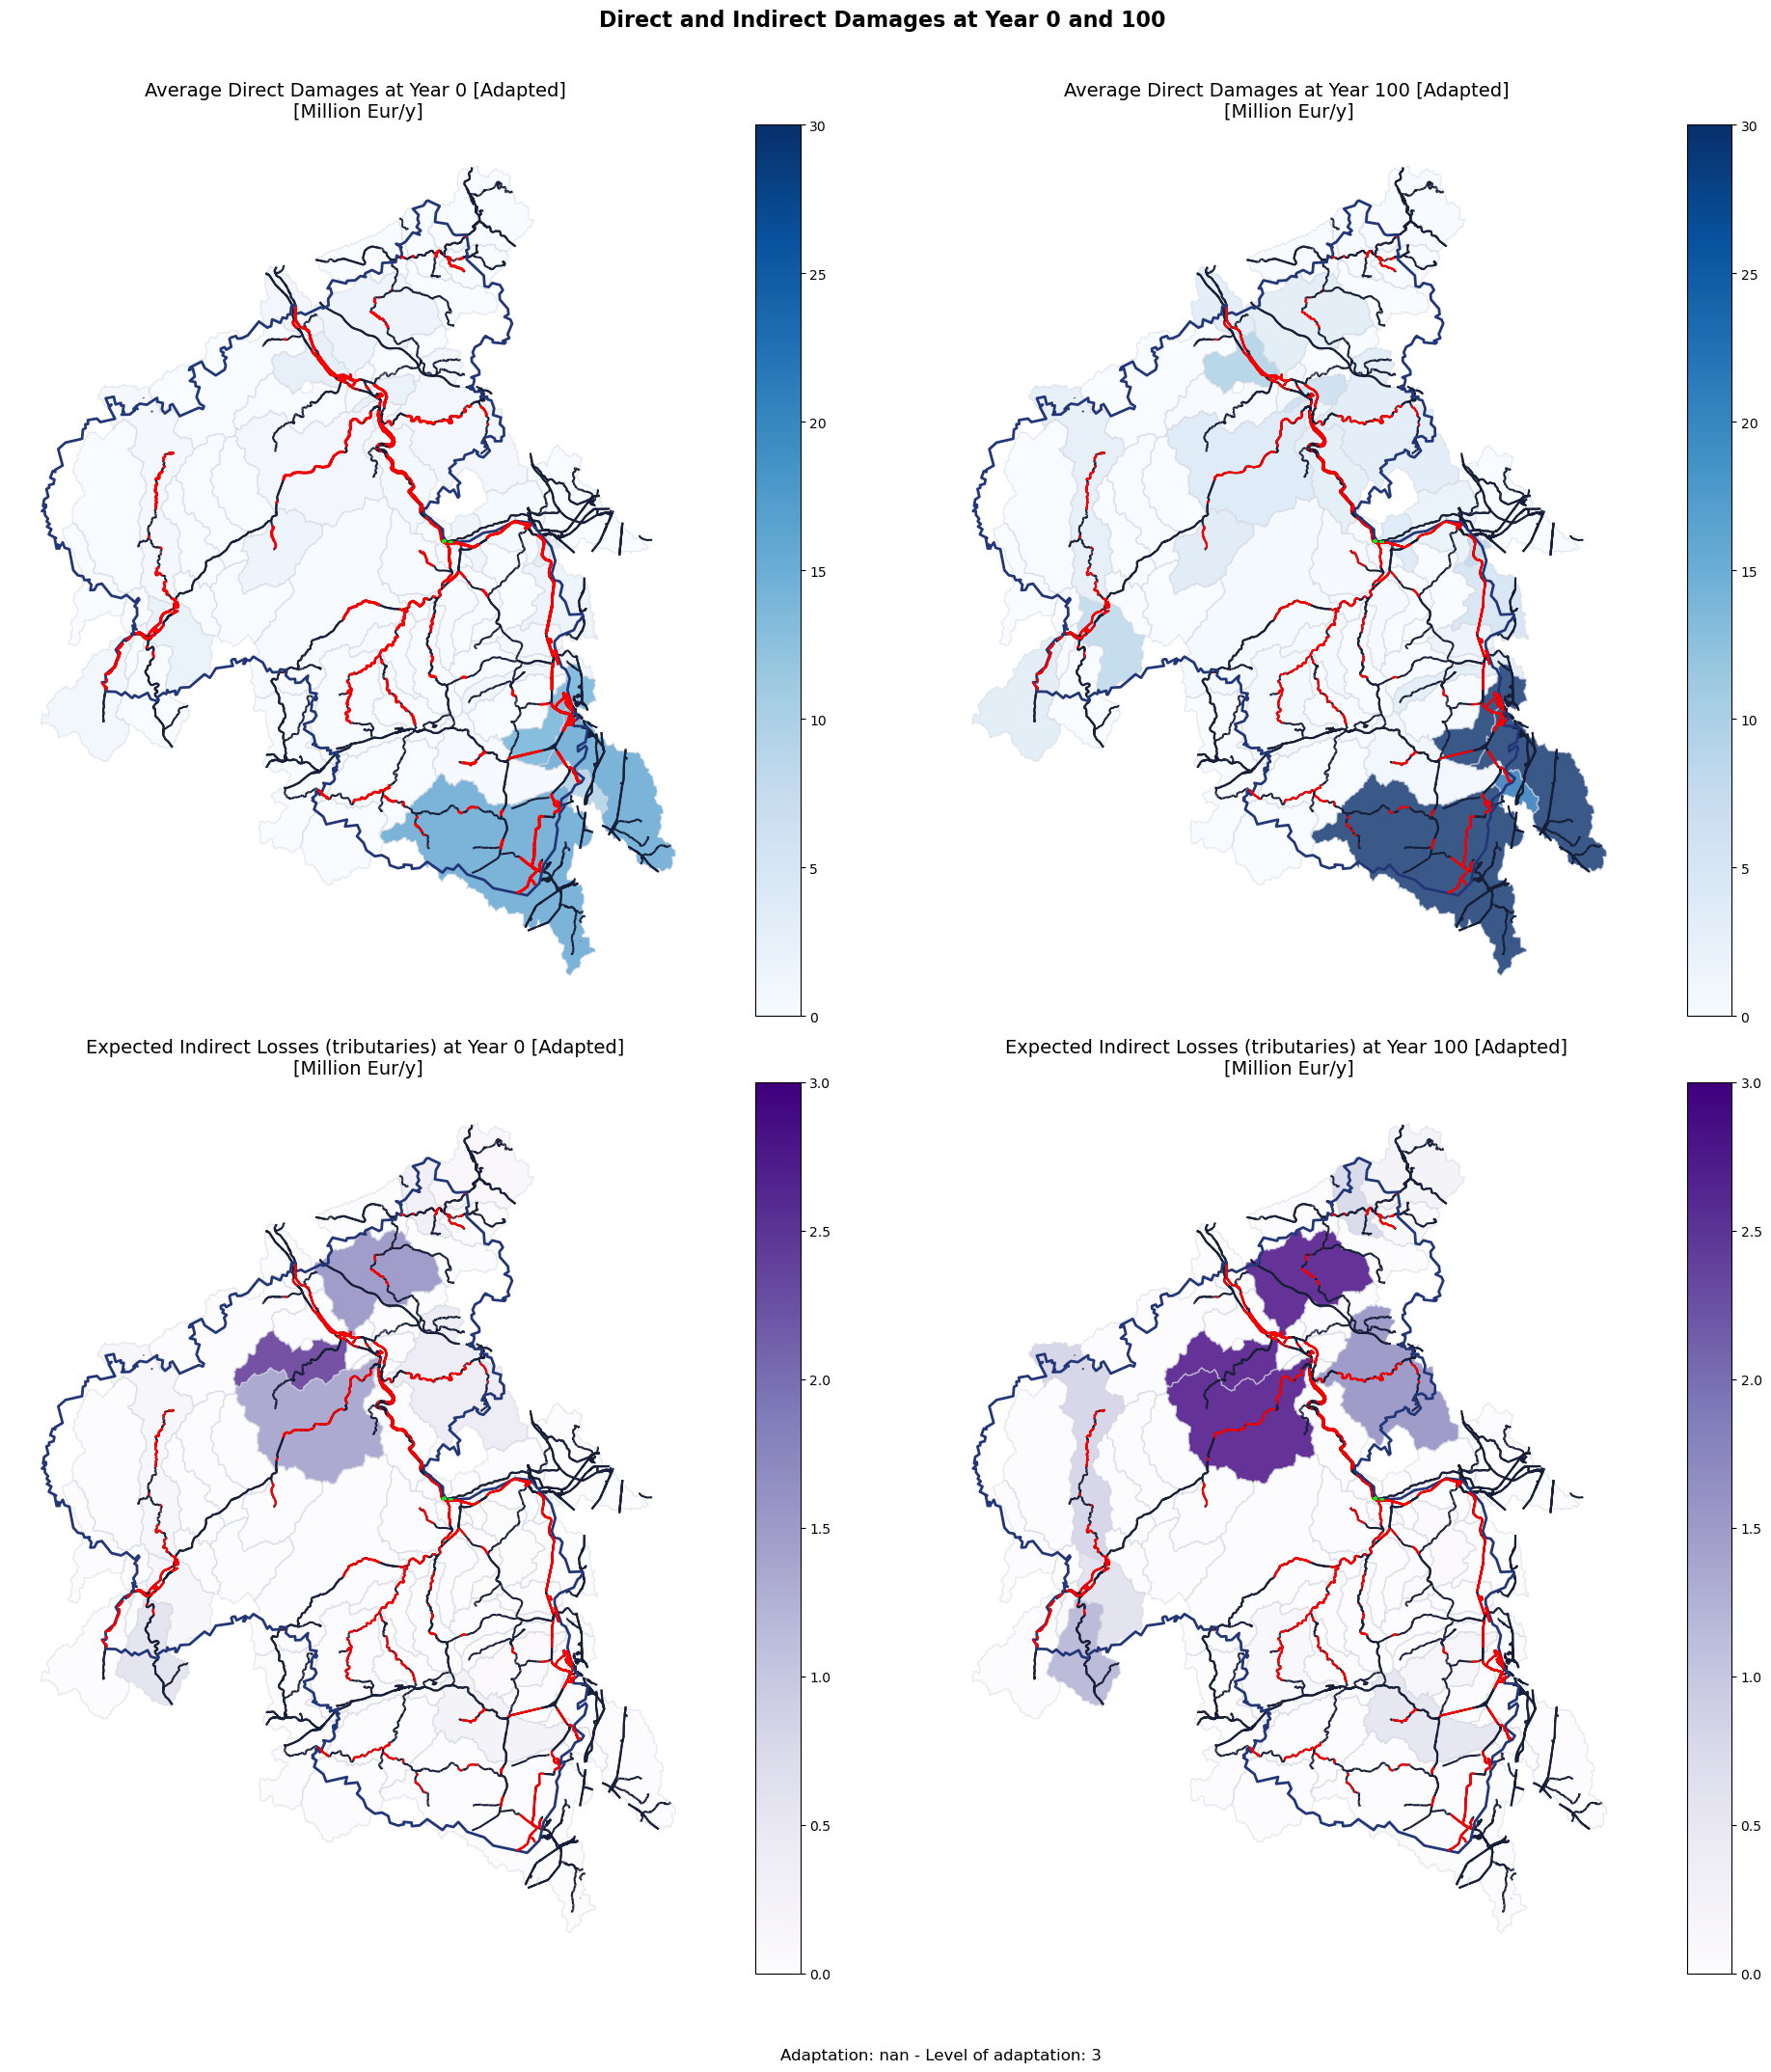

In [26]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Plot assets
for ax in axs.flat:
    assets_4326.plot(ax=ax, color=miraca_colors['black'], markersize=1)

# Direct damages
# Plot for year 0
ax=0,0
vmax_dd = math.ceil(max([eadD_ad_by_ts_by_basin[basin].values[0].max() for basin in eadD_ad_by_ts_by_basin]) / 10.0) * 10
basins_gdf_reduced.plot(column='Average EAD_D_ad_t0', ax=axs[ax], legend=True, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2, linewidth=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
axs[ax].set_title('Average Direct Damages at Year 0 [Adapted] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

# Plot for year 100
ax=0,1
valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
basins_gdf_reduced.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=True, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)

regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
axs[ax].set_title('Average Direct Damages at Year 100 [Adapted] \n[Million Eur/y]',fontsize=14)
axs[ax].set_axis_off()

# Indirect losses, tributary basins
# Plot for year 0
ax=1,0
vmax_id = np.ceil(max([eadIT_ad_by_ts_by_basin[basin].values[0].max() for basin in eadIT_ad_by_ts_by_basin]))
basins_gdf_reduced.plot(column='EAD_ID_ad_t0', ax=axs[ax], legend=True, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)

# For ID only: Plot ods?
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
# od_geoms_plot.plot(ax=axs[1, 0], edgecolor='black', facecolor='yellow', markersize=40)
axs[ax].set_title('Expected Indirect Losses (tributaries) at Year 0 [Adapted] \n[Million Eur/y]',fontsize=14)
axs[ax].set_axis_off()

# Plot for year 100
ax=1,1
basins_gdf_reduced.plot(column='EAD_ID_ad_t100', ax=axs[ax], legend=True, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
axs[ax].set_title('Expected Indirect Losses (tributaries) at Year 100 [Adapted] \n[Million Eur/y]',fontsize=14)
axs[ax].set_axis_off()

plt.tight_layout()
plt.suptitle('Direct and Indirect Damages at Year 0 and 100', fontsize=16,
                fontweight='bold',
                y=1.03)

adaptation_name = adaptations_df['prot_area'][0]
adaptation_level = adaptations_df['adapt_level'][0]

plt.text(0, -0.1, f'Adaptation: {adaptation_name} - Level of adaptation: {adaptation_level}', ha='center', va='bottom', fontsize=12, transform=plt.gca().transAxes)

plt.show()



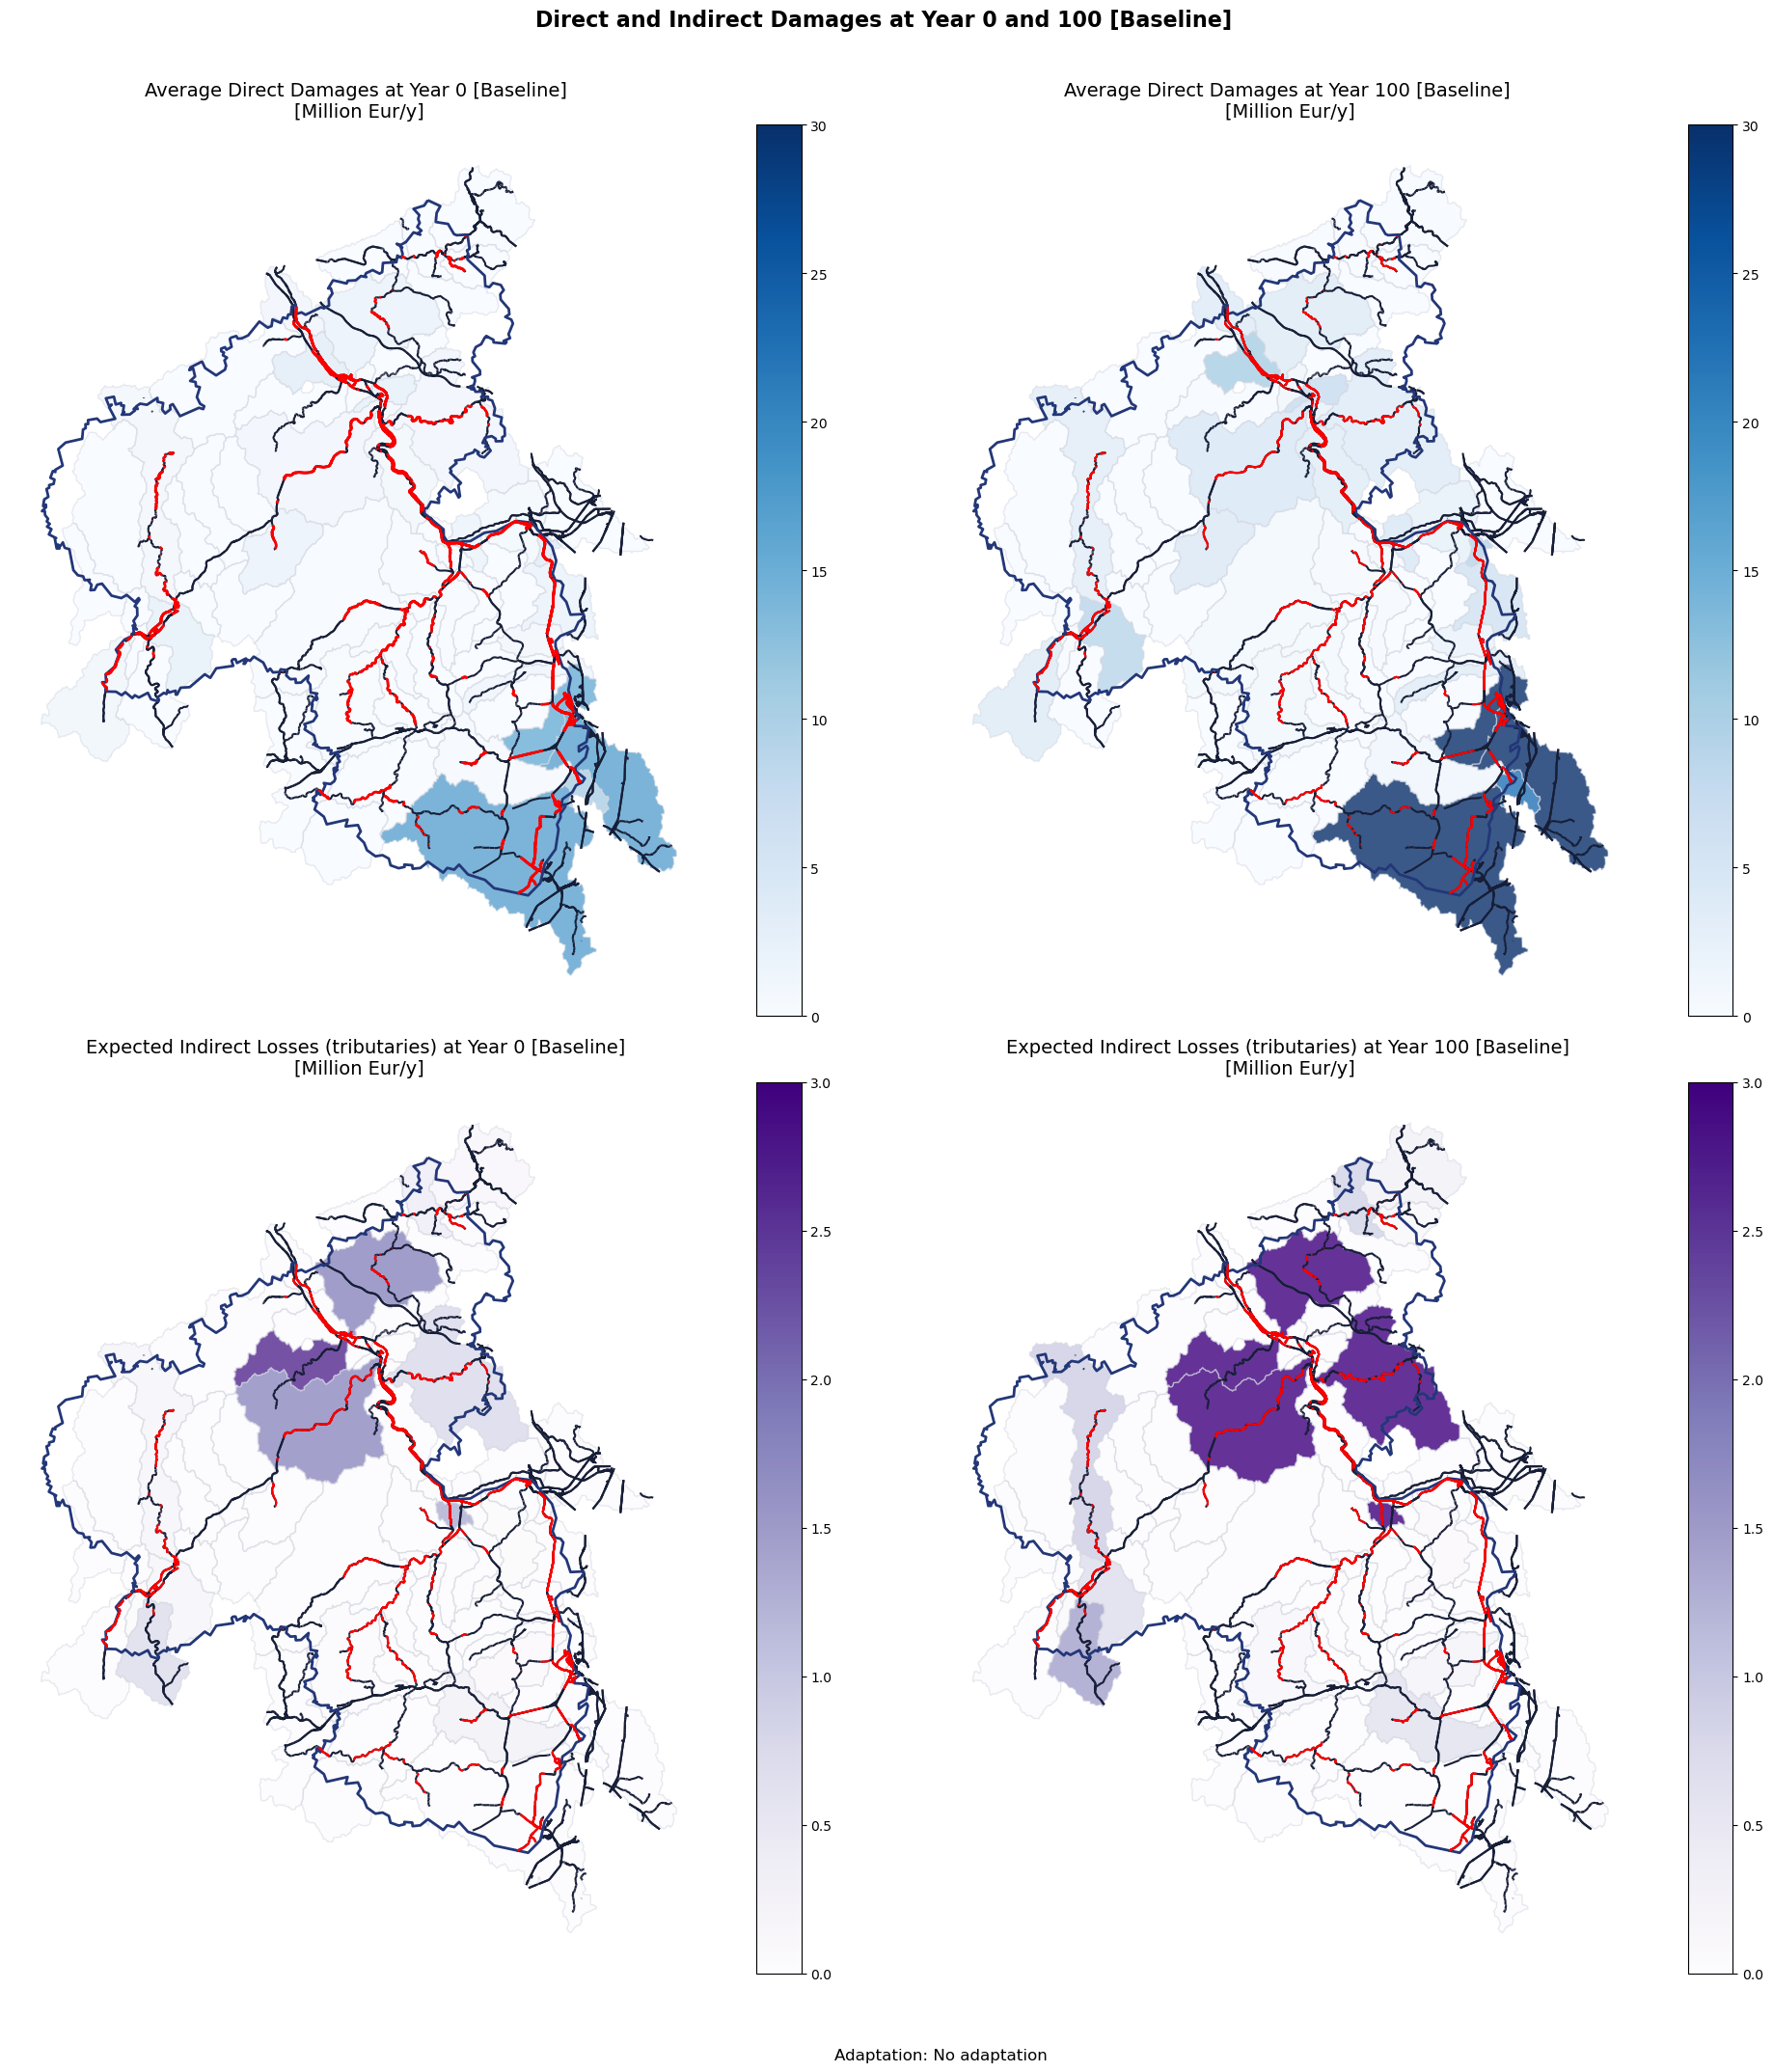

In [27]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Plot assets
for ax in axs.flat:
    assets_4326.plot(ax=ax, color=miraca_colors['black'], markersize=1)

# Direct damages
# Plot for year 0
ax = 0, 0
vmax_dd = math.ceil(max([eadD_bl_by_ts_by_basin[basin].values[0].max() for basin in eadD_bl_by_ts_by_basin]) / 10.0) * 10
basins_gdf_reduced.plot(column='Average EAD_D_bl_t0', ax=axs[ax], legend=True, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2, linewidth=2)
axs[ax].set_title('Average Direct Damages at Year 0 [Baseline] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

# Plot for year 100
ax = 0, 1
valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
basins_gdf_reduced.plot(column='Average EAD_D_bl_t100', ax=axs[ax], legend=True, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)

regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)

axs[ax].set_title('Average Direct Damages at Year 100 [Baseline] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

# Indirect losses, tributary basins
# Plot for year 0
ax = 1, 0
vmax_id = np.ceil(max([eadIT_bl_by_ts_by_basin[basin].values[0].max() for basin in eadIT_bl_by_ts_by_basin]))
basins_gdf_reduced.plot(column='EAD_ID_bl_t0', ax=axs[ax], legend=True, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)

# For ID only: Plot ods?
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)

# od_geoms_plot.plot(ax=axs[1, 0], edgecolor='black', facecolor='yellow', markersize=40)
axs[ax].set_title('Expected Indirect Losses (tributaries) at Year 0 [Baseline] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

# Plot for year 100
ax = 1, 1
basins_gdf_reduced.plot(column='EAD_ID_bl_t100', ax=axs[ax], legend=True, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)

axs[ax].set_title('Expected Indirect Losses (tributaries) at Year 100 [Baseline] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

plt.tight_layout()
plt.suptitle('Direct and Indirect Damages at Year 0 and 100 [Baseline]', fontsize=16,
             fontweight='bold',
             y=1.03)


plt.text(0, -0.1, f'Adaptation: No adaptation', ha='center', va='bottom', fontsize=12, transform=plt.gca().transAxes)

plt.show()



c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A

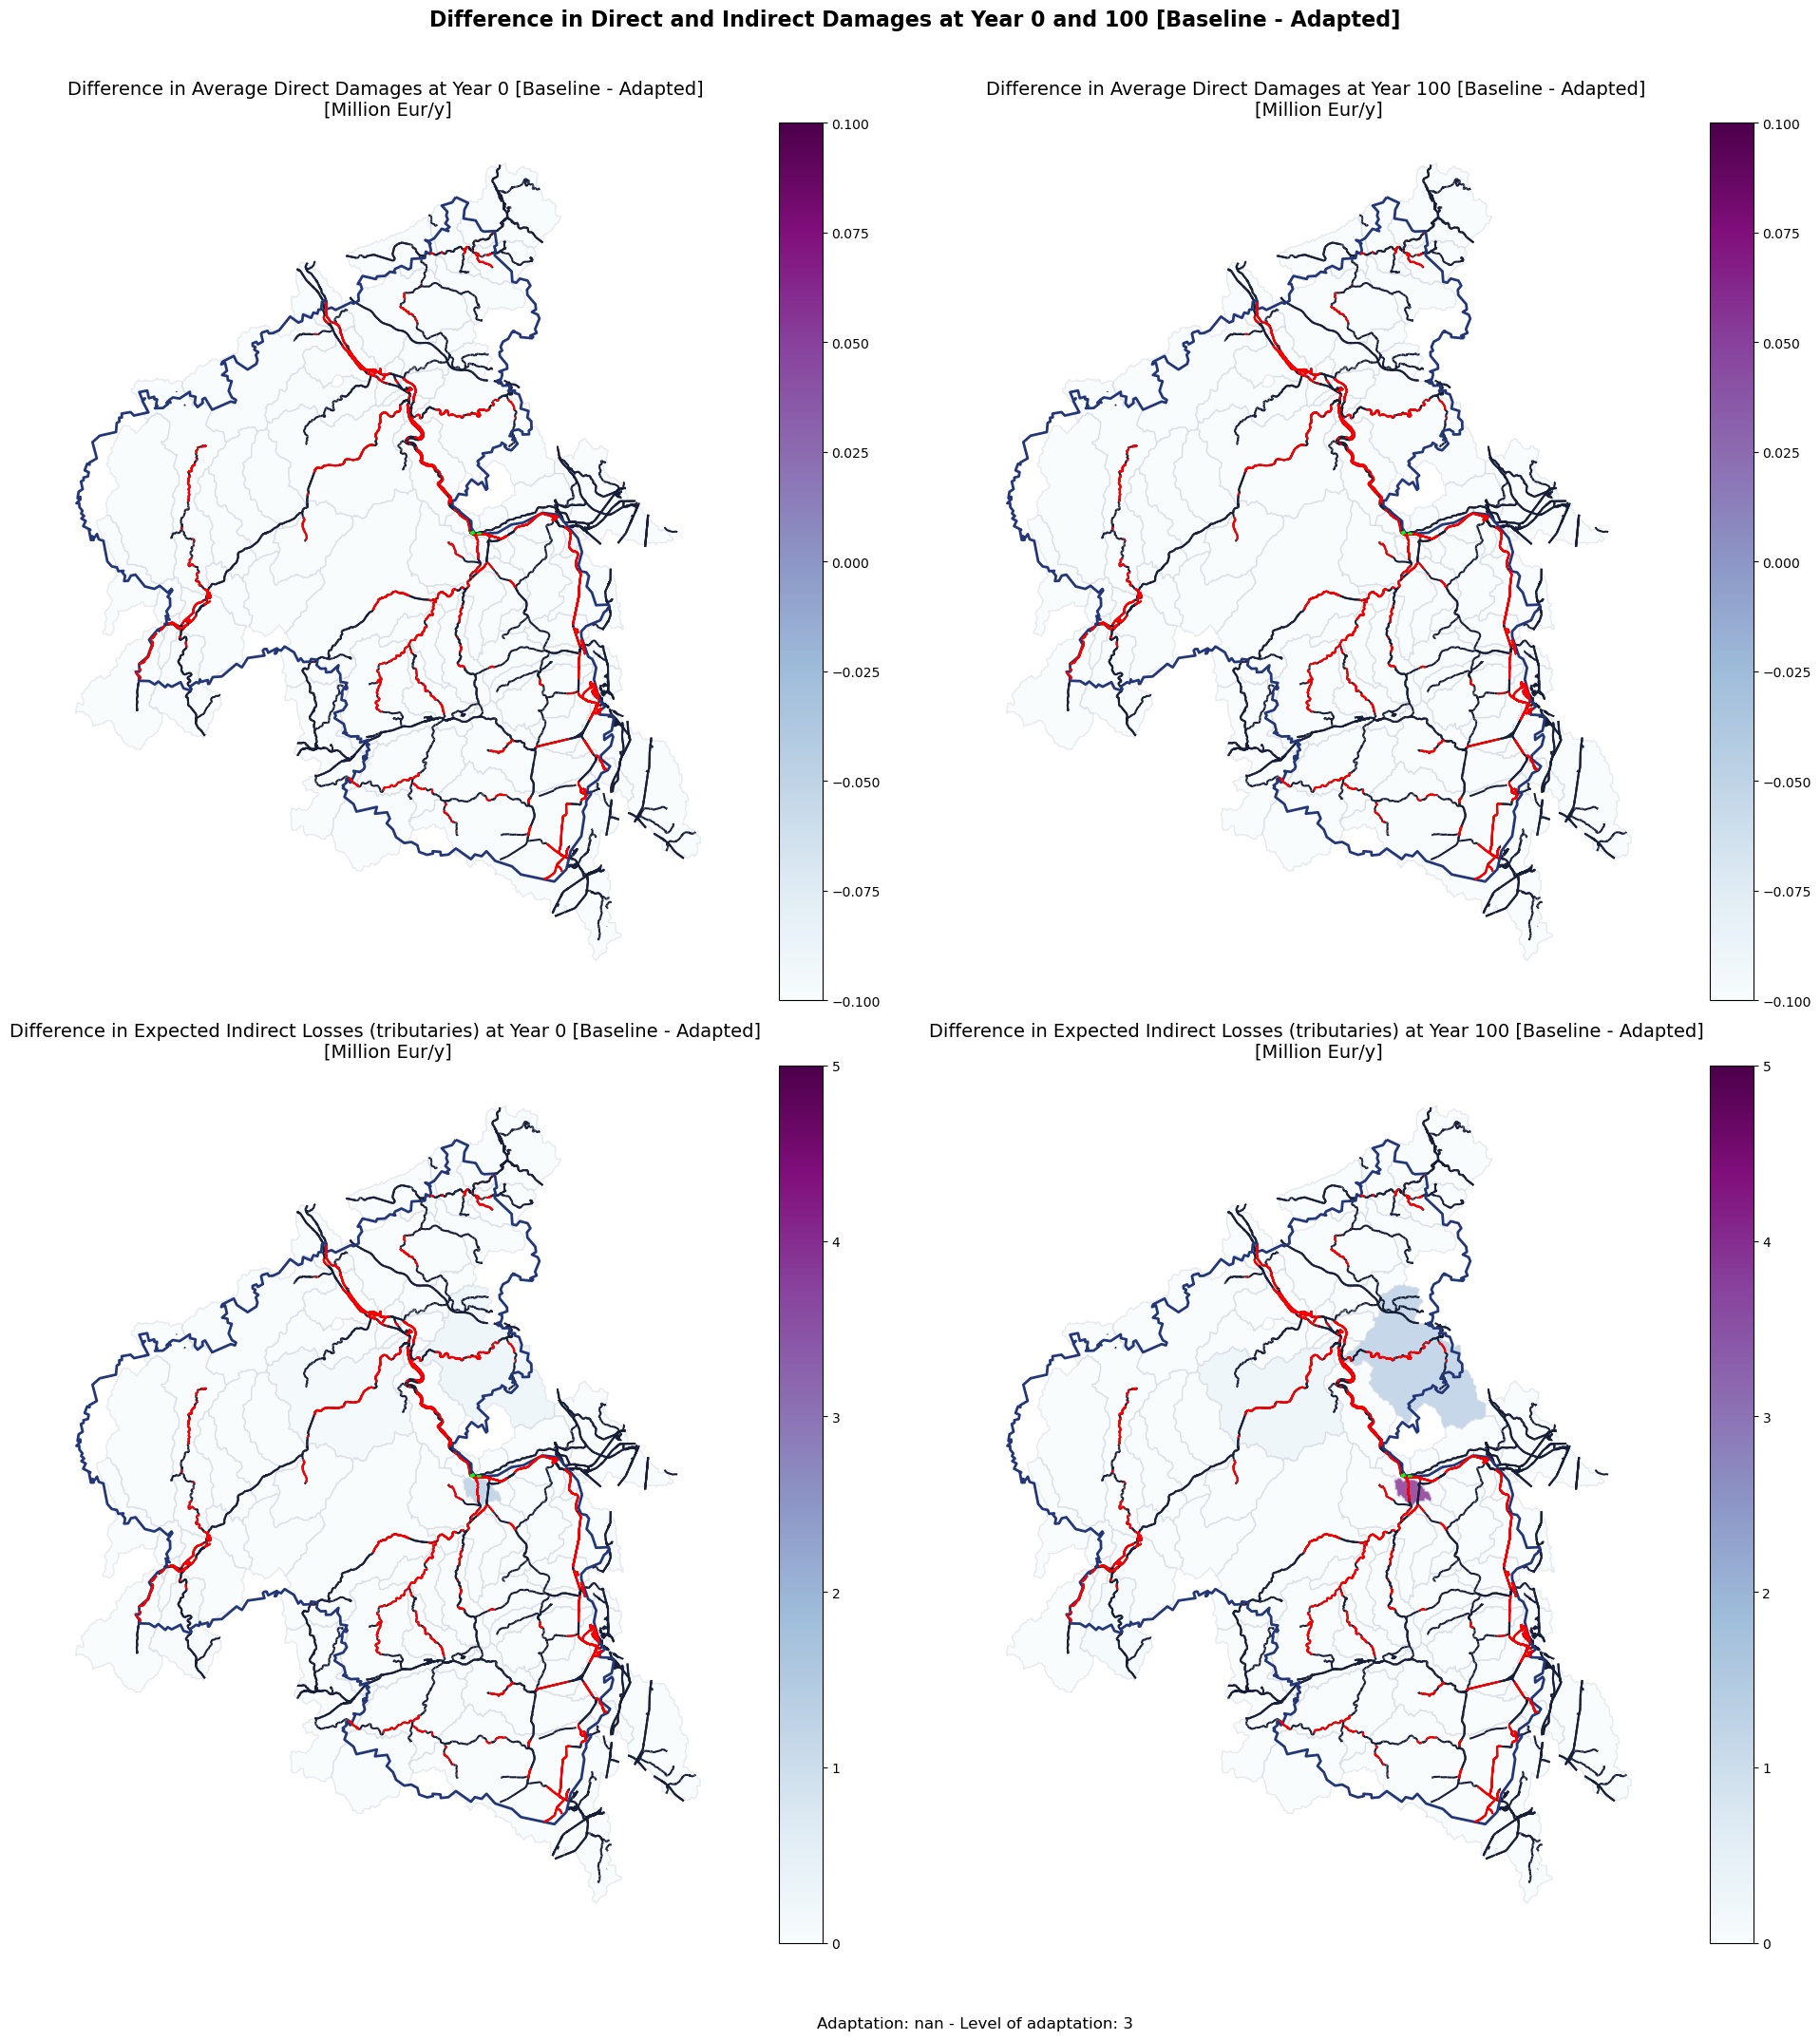

In [28]:
# repeat the plot with the difference of baseline and adapted damages at year 0 and at year 100 by adding a difference column for y0 direct, y100 direct, y0 indirect, y100 indirect

basins_gdf_reduced['Difference EAD_D_bl_ad_t0'] = basins_gdf_reduced['Average EAD_D_bl_t0'] - basins_gdf_reduced['Average EAD_D_ad_t0']
basins_gdf_reduced['Difference EAD_D_bl_ad_t100'] = basins_gdf_reduced['Average EAD_D_bl_t100'] - basins_gdf_reduced['Average EAD_D_ad_t100']

basins_gdf_reduced['Difference EAD_ID_bl_ad_t0'] = basins_gdf_reduced['EAD_ID_bl_t0'] - basins_gdf_reduced['EAD_ID_ad_t0']
basins_gdf_reduced['Difference EAD_ID_bl_ad_t100'] = basins_gdf_reduced['EAD_ID_bl_t100'] - basins_gdf_reduced['EAD_ID_ad_t100']

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Plot assets
for ax in axs.flat:
    assets_4326.plot(ax=ax, color=miraca_colors['black'], markersize=1)

# Direct damages
# Plot for year 0
ax = 0, 0
vmax_dd = math.ceil(max([basins_gdf_reduced['Difference EAD_D_bl_ad_t0'].max(), basins_gdf_reduced['Difference EAD_D_bl_ad_t100'].max()]))
basins_gdf_reduced.plot(column='Difference EAD_D_bl_ad_t0', ax=axs[ax], legend=True, cmap='BuPu', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
axs[ax].set_title('Difference in Average Direct Damages at Year 0 [Baseline - Adapted] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()    

# Plot for year 100
ax = 0, 1
basins_gdf_reduced.plot(column='Difference EAD_D_bl_ad_t100', ax=axs[ax], legend=True, cmap='BuPu', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
axs[ax].set_title('Difference in Average Direct Damages at Year 100 [Baseline - Adapted] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

# Indirect losses, tributary basins
# Plot for year 0
ax = 1, 0
vmax_id = np.ceil(max([basins_gdf_reduced['Difference EAD_ID_bl_ad_t0'].max(), basins_gdf_reduced['Difference EAD_ID_bl_ad_t100'].max()]))
basins_gdf_reduced.plot(column='Difference EAD_ID_bl_ad_t0', ax=axs[ax], legend=True, cmap='BuPu', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
axs[ax].set_title('Difference in Expected Indirect Losses (tributaries) at Year 0 [Baseline - Adapted] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

# Plot for year 100
ax = 1, 1
basins_gdf_reduced.plot(column='Difference EAD_ID_bl_ad_t100', ax=axs[ax], legend=True, cmap='BuPu', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
regions_gdf.boundary.plot(ax=axs[ax], edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=2)
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326.index]
    assets_4326.loc[valid_asset_ids].plot(ax=axs[ax], color=dic_colors[rp_def], markersize=2)
try:
    assets_4326.loc[adapted_assets.index].plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
except:
    try:
        adapted_assets.to_crs('EPSG:4326').plot(ax=axs[ax], color='#00fc0f', markersize=3, linewidth=3)
    except:pass
axs[ax].set_title('Difference in Expected Indirect Losses (tributaries) at Year 100 [Baseline - Adapted] \n[Million Eur/y]', fontsize=14)
axs[ax].set_axis_off()

plt.tight_layout()
plt.suptitle('Difference in Direct and Indirect Damages at Year 0 and 100 [Baseline - Adapted]', fontsize=16,
                fontweight='bold',
                y=1.03)
plt.text(0, -0.1, f'Adaptation: {adaptation_name} - Level of adaptation: {adaptation_level}', ha='center', va='bottom', fontsize=12, transform=plt.gca().transAxes)

plt.show()


In [ ]:
# Save the plots


In [26]:
total_damages_adapted_df_mill[total_damages_adapted_df_mill.index.str.contains('2080430320')]

return_period summed_adaptation_costs [M€]  \
flood_DERP_RW_H_4326_2080430320             H                          NaN   
flood_DERP_RW_M_4326_2080430320             M                          NaN   
flood_DERP_RW_L_4326_2080430320             L                          NaN   

                                                         summed_dd_bl [M€]  \
flood_DERP_RW_H_4326_2080430320  (0.22329212147988414, 0.2743757418432404)   
flood_DERP_RW_M_4326_2080430320   (0.2784084957824896, 1.0473738201867895)   
flood_DERP_RW_L_4326_2080430320    (9.355306384249477, 20.914827971012908)   

                                 direct damage baseline lower [M€]  \
flood_DERP_RW_H_4326_2080430320                              0.223   
flood_DERP_RW_M_4326_2080430320                              0.278   
flood_DERP_RW_L_4326_2080430320                              9.355   

                                 direct damage baseline upper [M€]  \
flood_DERP_RW_H_4326_2080430320                              0.274   
flood_DERP_RW_M_4326_2080430320                              1.047   
flood_DERP_RW_L_4326_2080430320                             20.915   

                                summed_dd_ad [M€]  \
flood_DERP_RW_H_4326_2080430320        (0.0, 0.0)   
flood_DERP_RW_M_4326_2080430320        (0.0, 0.0)   
flood_DERP_RW_L_4326_2080430320        (0.0, 0.0)   

                                 direct damage adapted lower [M€]  \
flood_DERP_RW_H_4326_2080430320                             0.000   
flood_DERP_RW_M_4326_2080430320                             0.000   
flood_DERP_RW_L_4326_2080430320                             0.000   

                                 direct damage adapted upper [M€]  \
flood_DERP_RW_H_4326_2080430320                             0.000   
flood_DERP_RW_M_4326_2080430320                             0.000   
flood_DERP_RW_L_4326_2080430320                             0.000   

                                indirect damage baseline [M€]  \
flood_DERP_RW_H_4326_2080430320                         0.047   
flood_DERP_RW_M_4326_2080430320                        15.428   
flood_DERP_RW_L_4326_2080430320                        77.142   

                                indirect damage adapted [M€]  
flood_DERP_RW_H_4326_2080430320                        0.000  
flood_DERP_RW_M_4326_2080430320                        0.000  
flood_DERP_RW_L_4326_2080430320                        0.012

In [29]:
basins_gdf_reduced[basins_gdf_reduced['HYBAS_ID']==2080430320]
# basins_gdf[basins_gdf['HYBAS_ID']==2080430320]


HYBAS_ID                                           geometry  \
6378  2080430320  POLYGON ((7.91667 49.88750, 7.91424 49.88785, ...   

      Average EAD_D_bl_t0  Average EAD_D_ad_t0  Average EAD_D_bl_t100  \
6378                0.175                0.000                  0.598   

      Average EAD_D_ad_t100  EAD_ID_bl_t0  EAD_ID_ad_t0  EAD_ID_bl_t100  \
6378                  0.000         1.317         0.000           3.978   

      EAD_ID_ad_t100  Difference EAD_D_bl_ad_t0  Difference EAD_D_bl_ad_t100  \
6378           0.000                      0.175                        0.598   

      Difference EAD_ID_bl_ad_t0  Difference EAD_ID_bl_ad_t100  
6378                       1.317                         3.977

Zoom Level: 8
Requesting OSM tiles...


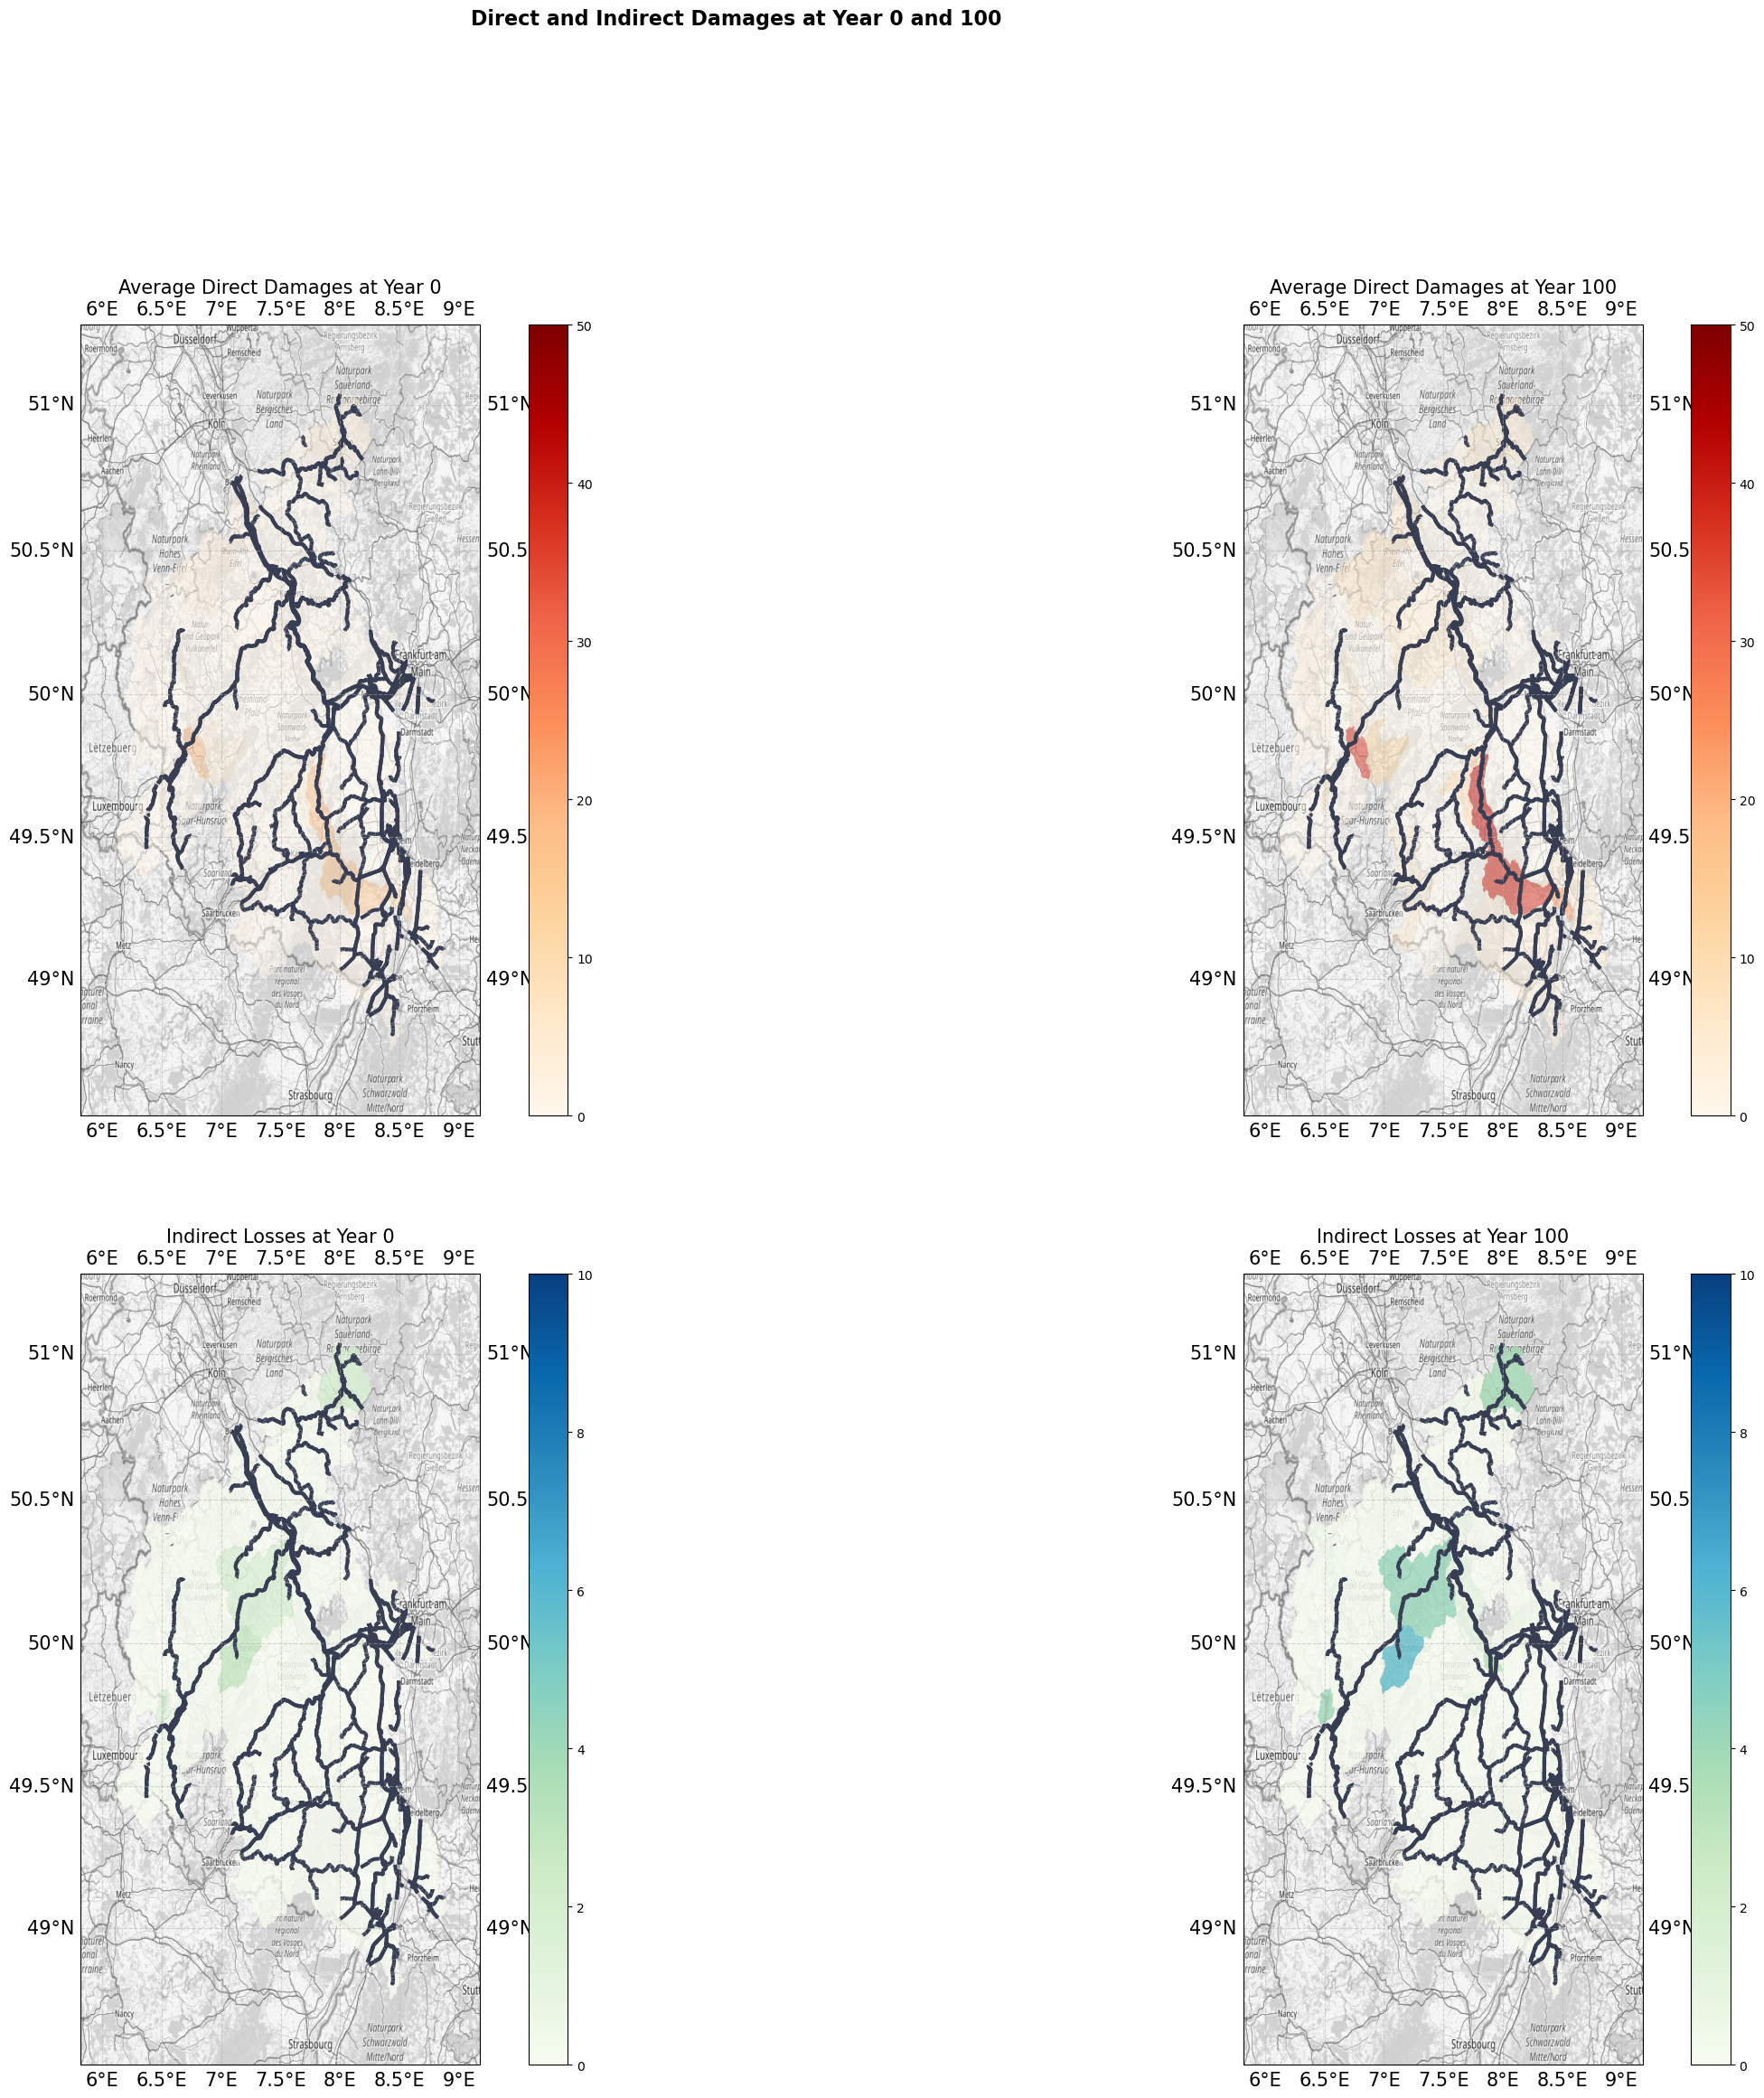

In [192]:
# Helper function
def zoomlevel_from_deg(deg):  # https://stackoverflow.com/questions/30052990/how-to-use-openstreetmap-background-on-matplotlib-basemap
    "Calculate OSM zoom level from a span in degrees. Adjust +/-1 as desired"
    from numpy import log2, clip, floor
    zoomlevel = int(clip(floor(log2(360) - log2(deg)), 0, 20))
    return zoomlevel

# Calculate extent and aspect ratio
extent = basins_gdf.total_bounds
clearance = 0.1
lon_min, lat_min, lon_max, lat_max = extent
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min

lon_min -= clearance * lon_range
lat_min -= clearance * lat_range
lon_max += clearance * lon_range
lat_max += clearance * lat_range

aspect_ratio = lon_range / lat_range

lon_i = lon_min + (lon_max - lon_min) / 2
lat_i = lat_min + (lat_max - lat_min) / 2
delta = 0.0016
zoom = zoomlevel_from_deg(delta) - 9
print(f"Zoom Level: {zoom}")

# Create a plot with the OSM tiles
print('Requesting OSM tiles...')
request_osm = cimgt.OSM(desired_tile_form="L")

fig, axs = plt.subplots(2, 2, figsize=(25 * aspect_ratio, 25), subplot_kw={'projection': request_osm.crs})

for ax in axs.flat:
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_image(request_osm, zoom, alpha=0.9, cmap='gray')

# Plot assets
# plot_assets.plot(ax=ax, color=miraca_colors['grey_900'], linewidth=3, transform=ccrs.PlateCarree())

# # Plot the affected assets
# plot_assets_affected = assets.iloc[disrupted_asset_ids_filt].drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
# plot_assets_affected.plot(ax=ax, color='red', linewidth=4, transform=ccrs.PlateCarree())

# assets_4326.plot(ax=axs[0, 0], color=miraca_colors['grey_'], markersize=1, transform=ccrs.PlateCarree())
# assets_4326.plot(ax=axs[0, 1], color='black', markersize=1, transform=ccrs.PlateCarree())
# assets_4326.plot(ax=axs[1, 0], color='black', markersize=1, transform=ccrs.PlateCarree())
# assets_4326.plot(ax=axs[1, 1], color='black', markersize=1, transform=ccrs.PlateCarree())
assets_4326.plot(ax=axs[0, 0], color=miraca_colors['grey_900'], markersize=1, linewidth=3, transform=ccrs.PlateCarree())
assets_4326.plot(ax=axs[0, 1], color=miraca_colors['grey_900'], markersize=1, linewidth=3, transform=ccrs.PlateCarree())
assets_4326.plot(ax=axs[1, 0], color=miraca_colors['grey_900'], markersize=1, linewidth=3, transform=ccrs.PlateCarree())
assets_4326.plot(ax=axs[1, 1], color=miraca_colors['grey_900'], markersize=1, linewidth=3, transform=ccrs.PlateCarree())

# Direct damages
basins_gdf_reduced.plot(column='Average EAD_D_ad_t0', ax=axs[0, 0], legend=True, cmap='OrRd', alpha=0.5, vmin=0, vmax=50, transform=ccrs.PlateCarree())
basins_gdf_reduced.plot(column='Average EAD_D_ad_t100', ax=axs[0, 1], legend=True, cmap='OrRd', alpha=0.5, vmin=0, vmax=50, transform=ccrs.PlateCarree())

# Indirect losses, tributary basins
basins_gdf_reduced.plot(column='EAD_ID_ad_t0', ax=axs[1, 0], legend=True, cmap='GnBu', alpha=0.8, vmin=0, vmax=10, transform=ccrs.PlateCarree())
basins_gdf_reduced.plot(column='EAD_ID_ad_t100', ax=axs[1, 1], legend=True, cmap='GnBu', alpha=0.8, vmin=0, vmax=10, transform=ccrs.PlateCarree())

# Set titles
axs[0, 0].set_title('Average Direct Damages at Year 0', fontsize=15)
axs[0, 1].set_title('Average Direct Damages at Year 100', fontsize=15)
axs[1, 0].set_title('Indirect Losses at Year 0', fontsize=15)
axs[1, 1].set_title('Indirect Losses at Year 100', fontsize=15)

# Add gridlines
for ax in axs.flat:
    ax.gridlines(draw_labels=True, xlabel_style={'size': 15}, ylabel_style={'size': 15}, alpha=0.5, linestyle='--')

# plt.tight_layout()
plt.suptitle('Direct and Indirect Damages at Year 0 and 100', fontsize=16, fontweight='bold', y=1.02)
plt.show()


In [26]:
total_damages_adapted_df_mill[total_damages_adapted_df_mill['direct damage baseline lower [M€]']-total_damages_adapted_df_mill['direct damage adapted lower [M€]'] !=0]

return_period summed_adaptation_costs [M€]  \
flood_DERP_RW_H_4326_2080430320             H                          NaN   
flood_DERP_RW_M_4326_2080430320             M                          NaN   
flood_DERP_RW_L_4326_2080430320             L                          NaN   
flood_DERP_RW_L_4326_2080428500             L                          NaN   

                                                         summed_dd_bl [M€]  \
flood_DERP_RW_H_4326_2080430320  (0.22329212147988414, 0.2743757418432404)   
flood_DERP_RW_M_4326_2080430320   (0.2784084957824896, 1.0473738201867895)   
flood_DERP_RW_L_4326_2080430320    (9.355306384249477, 20.914827971012908)   
flood_DERP_RW_L_4326_2080428500   (0.3137849323412469, 11.686856948618821)   

                                 direct damage baseline lower [M€]  \
flood_DERP_RW_H_4326_2080430320                              0.223   
flood_DERP_RW_M_4326_2080430320                              0.278   
flood_DERP_RW_L_4326_2080430320                              9.355   
flood_DERP_RW_L_4326_2080428500                              0.314   

                                 direct damage baseline upper [M€]  \
flood_DERP_RW_H_4326_2080430320                              0.274   
flood_DERP_RW_M_4326_2080430320                              1.047   
flood_DERP_RW_L_4326_2080430320                             20.915   
flood_DERP_RW_L_4326_2080428500                             11.687   

                                summed_dd_ad [M€]  \
flood_DERP_RW_H_4326_2080430320        (0.0, 0.0)   
flood_DERP_RW_M_4326_2080430320        (0.0, 0.0)   
flood_DERP_RW_L_4326_2080430320        (0.0, 0.0)   
flood_DERP_RW_L_4326_2080428500        (0.0, 0.0)   

                                 direct damage adapted lower [M€]  \
flood_DERP_RW_H_4326_2080430320                             0.000   
flood_DERP_RW_M_4326_2080430320                             0.000   
flood_DERP_RW_L_4326_2080430320                             0.000   
flood_DERP_RW_L_4326_2080428500                             0.000   

                                 direct damage adapted upper [M€]  \
flood_DERP_RW_H_4326_2080430320                             0.000   
flood_DERP_RW_M_4326_2080430320                             0.000   
flood_DERP_RW_L_4326_2080430320                             0.000   
flood_DERP_RW_L_4326_2080428500                             0.000   

                                indirect damage baseline [M€]  \
flood_DERP_RW_H_4326_2080430320                         0.047   
flood_DERP_RW_M_4326_2080430320                        15.428   
flood_DERP_RW_L_4326_2080430320                        77.142   
flood_DERP_RW_L_4326_2080428500                        47.179   

                                indirect damage adapted [M€]  
flood_DERP_RW_H_4326_2080430320                        0.046  
flood_DERP_RW_M_4326_2080430320                        1.893  
flood_DERP_RW_L_4326_2080430320                       77.142  
flood_DERP_RW_L_4326_2080428500                       47.179

In [ ]:
aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))

# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# for a list of all the basins in the region, retrieve the upper and lower damage bounds for each basin and skip if the basin is not a key in the summed_output dictionary

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = sorted_total_damages_adapted_df_mill.loc[key]['summed_dd_ad [M€]']


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

ead_y0_dd_ad = ead_by_ts_by_basin[basin].values[0]
ead_y100_dd_ad = ead_by_ts_by_basin[basin].values[-1]
total_cost_dd_ad = sum(ead_by_ts_by_basin[basin].values)
print(f'EAD at year 0 for basin {basin}: {ead_y0_dd_ad}')
print(f'EAD at year 100 for basin {basin}: {ead_y100_dd_ad}')
print(f'Total direct damages for basin {basin}: {total_cost_dd_ad}')

In [ ]:
files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = sorted_total_damages_adapted_df_mill.loc[key]['indirect damage adapted [M€]']


for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])

ead_y0_id_ad = ead_by_ts_by_basin[basin].values[0]
ead_y100_id_ad = ead_by_ts_by_basin[basin].values[-1]
total_cost_id_ad = sum(ead_by_ts_by_basin[basin].values)
print(f'EAD at year 0 for basin {basin}: {ead_y0_id_ad}')
print(f'EAD at year 100 for basin {basin}: {ead_y100_id_ad}')
print(f'Total indirect losses for basin {basin}: {total_cost_id_ad}')

In [ ]:

print(direct_damages_adapted['flood_DERP_RW_H_4326_2080411370'][2])

# Ensure each entry in event_impacts contains both 'direct_damages' and 'indirect_damages'
# Adjust the dictionary if necessary
for key, value in event_impacts.items():
    if isinstance(value, dict):
        if 'direct_damages' not in value:
            value['direct_damages'] = 0  # or some default value
        if 'indirect_damages' not in value:
            value['indirect_damages'] = 0  # or some default value
    else:
        event_impacts[key] = {'direct_damages': direct_damages_adapted[key][0], 'indirect_damages': value}  # or some default value

# Create the DataFrame
baseline_impacts_by_hazard_map = pd.DataFrame.from_dict(event_impacts, orient='index', columns=['direct_damages', 'indirect_damages'])
baseline_impacts_by_hazard_map